In [1]:
import pandas as pd

df = pd.read_csv("logs4.csv.gz", parse_dates=[1])

In [2]:
len(df)

3465369

In [3]:
df.dtypes

ogpweb#               int64
date         datetime64[ns]
request              object
code                  int64
bytes                 int64
referrer             object
useragent            object
source               object
rt                  float64
urt                 float64
dtype: object

<AxesSubplot:ylabel='Frequency'>

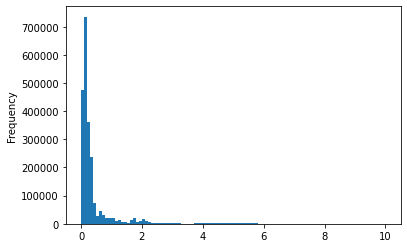

In [5]:
df['urt'].plot.hist(bins=100, range=[0,10])

# Processing time per page

In [6]:
def bucket(r):
    r = r.rsplit('HTTP/')[0].split('GET ')[-1]
    for s in ('?', '/dataset/', '/reference/', '/inventory/',
              '/comment/', '/node/', '/suggested-datasets/',
              '/4plan/', '/apps/'):
        if s in r:
            r = r.split(s)[0] + s + '…'
    return r
bdf = df[['request','urt']].copy(deep=True)
bdf['request'] = bdf['request'].map(bucket)

In [7]:
sdf = bdf.groupby(['request']).agg(['median','count','sum'])
sdf.columns = sdf.columns.map('_'.join)
sdf['urt_sum'] = sdf['urt_sum'] / (60*60*24)  # days

busy = sdf[(sdf['urt_count'] > 10) & (sdf['urt_sum'] > 0.02)]
busy.sort_values('urt_sum', ascending=False).rename(
    columns={'urt_sum':'urt_sum (days)'})

,urt_median,urt_count,urt_sum (days)
request,,,
/data/en/dataset?…,0.2550,487250,1.609140
/fr/search/contrats?…,5.4360,24223,1.548953
/data/en/dataset/…,0.1640,250468,0.731320
/en?…,2.0390,35920,0.721778
/en/search/contracts?…,4.2680,20354,0.709042
/en/external-comment/dataset/…,0.7390,66406,0.577958
/data/fr/dataset?…,0.2780,93247,0.332298
/en/comment/…,1.2990,18853,0.326770
/en/search/ati?…,0.1110,52463,0.255808


In [8]:
urt_sum_sum = sdf['urt_sum'].sum()
urt_sum_sum # total processing time in days

11.853326226851923

In [9]:
dsearch_sum = bdf[bdf['request'].str.contains('/search/')]['urt'].sum() / (60*60*24) # days
print("%0.2f days processing drupal search" % (dsearch_sum))
print("%0.2f %% urt" % (dsearch_sum / urt_sum_sum * 100))

3.43 days processing drupal search
28.97 % urt


# Requests vs processing time per app

In [10]:
df['search'] = df['urt'].notna() & df['request'].str.contains(r'/(?:od|bn|ct|ei|gc|nap|si|qp|sd)/')
df['ckan'] = df['urt'].notna() & df['request'].str.contains(' /data/')
df['drupal'] = df['urt'].notna() & ~ df['search'] & ~ df['ckan']

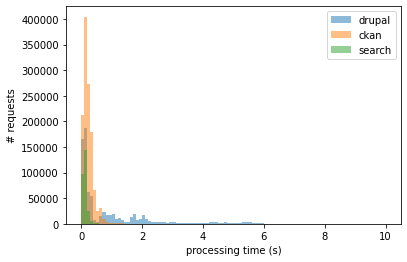

In [11]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.hist(df[df['drupal']]['urt'], alpha=0.5, bins=100, range=[0,10],  label='drupal')
ax.hist(df[df['ckan']]['urt'], alpha=0.5, bins=100, range=[0,10],  label='ckan')
ax.hist(df[df['search']]['urt'], alpha=0.5, bins=100, range=[0,10], label='search')
ax.legend(loc='upper right')
ax.set_ylabel('# requests')
ax.set_xlabel('processing time (s)')
plt.show()

# Processing time per CKAN API call

In [12]:
cadf = df[df['request'].str.contains('/action/')][
    ['request','urt']].copy(deep=True)
cadf['request'] = cadf['request'].str.extract(r'/action/(\w+)')

In [13]:
scadf = cadf.groupby(['request']).agg(['median','count','sum'])
scadf.columns = scadf.columns.map('_'.join)
scadf['urt_sum'] = scadf['urt_sum'] / 60  # minutes
scadf.sort_values('urt_sum', ascending=False).rename(
    columns={'urt_sum':'urt_sum (minutes)'})

,urt_median,urt_count,urt_sum (minutes)
request,,,
package_update,1.6400,2946,96.848617
package_show,0.0370,101000,68.686383
package_search,0.2290,3356,23.820983
organization_list,5.9250,210,20.818433
package_create,4.0130,29,1.845783
package_list,1.3590,20,0.459350
recently_changed_packages_activity_list,0.1935,50,0.189917
package_delete,0.9350,12,0.162150
resource_search,3.3070,1,0.055117


# Cache simulation

In [14]:
import heapq
from datetime import datetime, timedelta

def csim(expire):
    h = []
    c = set()
    def lookup(row):
        dt = row['date']
        req = row['request']
        while h and h[0][0] + expire < dt:
            c.remove(h[0][1])
            heapq.heappop(h)
        if req in c:
            return True
        heapq.heappush(h, (dt, req))
        c.add(req)
        return False
    return lookup

In [15]:
cdf = df[df['urt'].notna() & df['request'].str.match('GET ')][
    ['ogpweb#','date','request','urt']].copy(deep=True)
cdf.sort_values(by='date', inplace=True)

In [16]:
cdf['1dhit'] = cdf.apply(csim(timedelta(days=1)), axis=1)

In [29]:
s1d = cdf[cdf['1dhit']][['urt']].sum()
print("%0.2f hours saved with 1d cache" % (s1d / 60 / 60))
print("%0.2f %% savings" % (s1d / 60 / 60 / 24 / urt_sum_sum * 100))

79.16 hours saved with 1d cache
27.83 % savings


In [18]:
cdf['1hhit'] = cdf.apply(csim(timedelta(hours=1)), axis=1)

In [30]:
s1h = cdf[cdf['1hhit']][['urt']].sum()
print("%0.2f hours saved with 1h cache" % (s1h / 60 / 60))
print("%0.2f %% savings" % (s1h / 60 / 60 / 24 / urt_sum_sum * 100))

43.90 hours saved with 1h cache
15.43 % savings


In [20]:
cdf['5mhit'] = cdf.apply(csim(timedelta(minutes=5)), axis=1)

In [31]:
s5m = cdf[cdf['5mhit']][['urt']].sum()
print("%0.2f hours saved with 5m cache" % (s5m / 60 / 60))
print("%0.2f %% savings" % (s5m / 60 / 60 / 24 / urt_sum_sum * 100))

23.81 hours saved with 5m cache
8.37 % savings


# Bots

In [22]:
agents = df[['useragent', 'urt']].groupby(['useragent']).count()
agents.sort_values('urt', ascending=False)[:20].rename(
    columns={'urt':'# requests'})

,# requests
useragent,
Mozilla/5.0 (compatible; SemrushBot/6~bl; +http://www.semrush.com/bot.html),272018
Mozilla/5.0 (compatible; AhrefsBot/7.0; +http://ahrefs.com/robot/),224101
Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm),159078
"Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.118 Mobile Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)",123473
Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html),115654
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36",79619
ckanapi/4.3 (+https://github.com/ckan/ckanapi),61617
Ruby,59838
"Mozilla/5.0 (Linux; Android 7.0;) AppleWebKit/537.36 (KHTML, like Gecko) Mobile Safari/537.36 (compatible; PetalBot;+https://aspiegel.com/petalbot)",57730


In [23]:
import re
df['bot'] = df['useragent'].str.extract(
    r'(aolbuild|baidu|bingbot|bingpreview|msnbot|duckduckgo'
    r'|adsbot-google|googlebot|mediapartners-google|teoma|slurp'
    r'|yandexbot|barkrowler|ccbot|csnibot|petalbot|sogou|applebot'
    r'|semrushbot|megaindex|siteimprove|ahrefsbot|tencenttraveler'
    r'|riddler|dotbot)', flags=re.IGNORECASE)

In [24]:
bots = df[df['bot'].notna()][['bot', 'urt']].copy()
bots['bot'] = bots['bot'].str.lower()
bots['urt'] = bots['urt'] / (60*60*24) # days
bots.groupby(['bot']).sum().sort_values('urt', ascending=False).rename(
    columns={'urt':'urt (days)'})

,urt (days)
bot,
googlebot,1.510967
petalbot,0.794687
ahrefsbot,0.630872
bingbot,0.622088
semrushbot,0.511885
dotbot,0.263357
sogou,0.209702
siteimprove,0.187817
riddler,0.148821


In [25]:
bot_sum = bots['urt'].sum()
print("%0.2f days processing bot traffic" % (bot_sum))
print("%0.2f %% urt" % (bot_sum / urt_sum_sum * 100))

5.38 days processing bot traffic
45.37 % urt


# Requests vs date per app

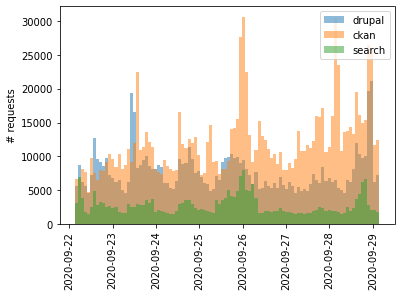

In [26]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.hist(df[df['drupal']]['date'], alpha=0.5, bins=100, label='drupal')
ax.hist(df[df['ckan']]['date'], alpha=0.5, bins=100, label='ckan')
ax.hist(df[df['search']]['date'], alpha=0.5, bins=100, label='search')
ax.legend(loc='upper right')
ax.set_ylabel('# requests')
plt.xticks(rotation=90)
plt.show()

# Potential Optimization Impact

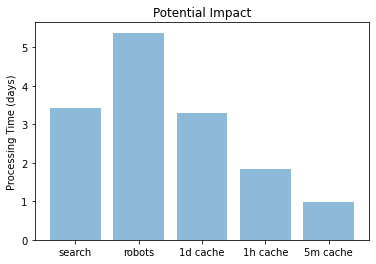

In [33]:
objects = ('search', 'robots', '1d cache', '1h cache', '5m cache')
y_pos = range(len(objects))
performance = [dsearch_sum, bot_sum, s1d/60/60/24, s1h/60/60/24, s5m/60/60/24]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Processing Time (days)')
plt.title('Potential Impact')

plt.show()